# Вам предстоит решать задачу классификации изображений методом логистической регрессии. 

В итоге вы должны получить  функцию $f(x) \to [0,1]^{10}$, которая на вход получает картинку с написанной от руки цифрой, а на выход дает 10 вероятностей от 0 до 1 принадлежности к каждому из классов (цифре). Картинка это вектор из (8*8) = 64 чисел. Мы будем рассматривать параметрическое семейство функций $F(c)$, таких,  что если $f_с \in F$, то она удовлетворяет нашим требованиям. Кроме того, для каждой функции  $f_c \in F$ мы можем посчитать, насколько она хорошо работает на некотором наборе картинок - это будет функционал качества этой функции $loss(f_c, images)$. Чем он меньше, тем лучше: в идеале $loss$ будет давать $0$ в том случае, если наша функция на всех картинках, на которых нарисована цифра $i$ выдала вектор, где все числа отличны от $1$ и только на $i-м$ месте стоит $1$. Иначе это будет некоторое положительное число, которое тем больше, чем хуже работает классификатор (потеря)

Итак, возьмем функцию $g(c) = loss(f_c, images)$ и будем ее минимизировать. Если мы найдем глобальный минимум, то научимся максимально качественно решать задачу классификации с помощью того семейства функций, которое мы выбрали. Глобальный минимум мы, конечно, не сможем аналитически найти, поэтому будем решать задачу минимизации методом градиентного спуска.

# Возьмем датасет нарисованных от руки картинок

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

import math
import scipy as sp
from sklearn.datasets import load_digits
from sklearn.cross_validation import train_test_split
import tqdm
import os
import csv


digits = load_digits()

/home/user/study/OptimizationMethods/lin_prog/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
pics = []
answers = []

pathname = './train'
for filename in os.listdir(pathname):
    if "indoor" in filename:
        pics.append(sp.misc.imread(os.path.join(pathname, filename)).flatten())
#         print(pics[-1])
        answers.append(0)
#         print(filename, "indoor")
    else:
        pics.append(sp.misc.imread(os.path.join(pathname, filename)).flatten())
        answers.append(1)
#         print(filename, "outdoor")

pics = np.array(pics)
answers = np.array(answers)

/home/user/study/OptimizationMethods/lin_prog/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
/home/user/study/OptimizationMethods/lin_prog/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  import sys


In [3]:
pics.shape

(6905, 3072)

In [4]:
answers.shape

(6905,)

In [5]:
np.max(pics)

255

# Пример содержимого датасета

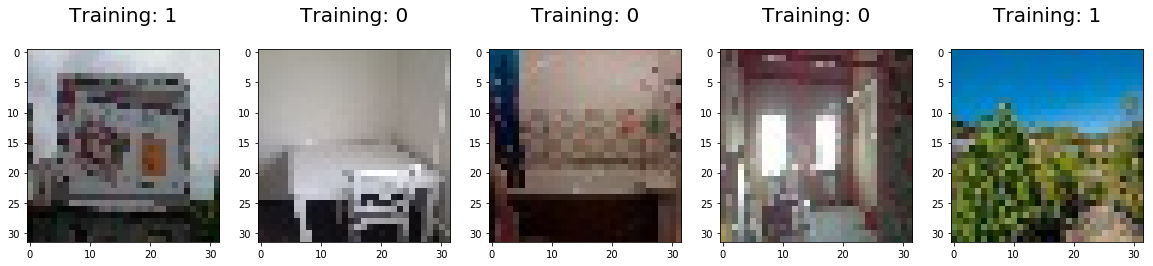

In [6]:
plt.figure(figsize=(20, 4))

for index, (image, label) in enumerate(zip(pics[0:5], answers[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (32, 32, 3)), cmap=plt.cm.gray)
    plt.title('Training: %i\n' % label, fontsize = 20)

# Разделим датасет на 2 части - train и validate
1. На первой мы будем решать оптимизационную задачу - искать такую функцию, которая по картинке выдает правильную цифру. 
2. На второй будем независимо проверять, насколько качественно работает наша функция

Это необходимо для того, чтобы понимать, насколько наша функция реально умеет решать поставленную задачу: понимать, где какая цифра. У нас ограниченная выборка - всего 1797 картинок. Но в реальности нарисованных цифр может быть значительно больше! Если даже наша функция безошибочно работает на всех 1797 картинках, но ошибается вне - это плохо. Обычно график обучения должен выглядит примерно так, если зеленое - обучающая выборка, а красное - валидационная

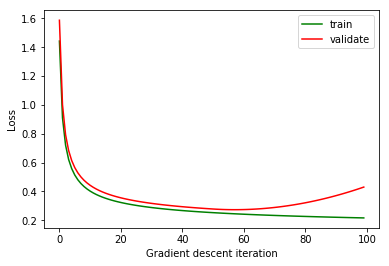

In [7]:
plt.plot(
    [1/math.log(i+2) for i in range(100)], 
    color='green', 
    label='train'
)

plt.plot(
    [1/math.log(i+2)*1.1+( (i/50.0-1)**2./5. if i>50 else 0.) for i in range(100)],
    color='red',
    label='validate')

plt.xlabel('Gradient descent iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

То есть с каждым шагом мы уменьшаем наш loss на обучающей выборке за счет градиентного спуска, но в какой-то момент функция может начать хорошо работать только на обучающей выборке. Этот эффект (в данном примере около 55 итерации по оси x) назвается переобучением.

# Вернемся к задаче
## Преобразуем числа от 0 до 9 в вектора из 10 элементов, где на i-m месте стоит 1, если цифра равна i и 0 иначе. 

## Также нормализуем картинки: все пиксели - это числа от 0 до 16. Сделаем их от -0.5 до 0.5, это улучшит качество нашей модели

In [8]:
def one_hot(y, n_classes):
    # делаем вектор из 10 координат с 0 везде кроме правильного ответа
    tmp = np.zeros(
        (len(y), n_classes), 
        dtype=np.uint8
    )
    tmp[range(len(tmp)), y] = 1
    return tmp

x_train, x_test, y_train, y_test = train_test_split(
    (pics - 127.5) / 255, 
    one_hot(answers, 2),
    test_size=0.33, 
    random_state=0
)

In [9]:
x_test.shape

(2279, 3072)

# Задание: реализовать методом градиентного спуска логистическую регрессию. Начиная с этой ячейки и ниже разрешено использовать только стандартные функции  python и библиотеки numpy и  matplotlib

Для каждой картинки (картинка представляет из себя вектор $x \in [-1, 1]^{64}$) мы хотим найти вектор $p = (p_0,\ldots,p_{9}) \in [0, 1]^{10}$, вероятностей, такой, что $p_i$ - вероятность того, что на картинка цифра $i$.

Реализуя логистическую регрессию, мы хотим приближать вероятности к их настоящему распределению. 

Выражение выдает ответ вида 
$$
A x + b
$$


где $x$ - наш вектор картинки, а результат - числовой вектор размерности $10$ с какими-то числами (в сумме не обязательно дают единицу). Для того, чтобы эти числа стали вероятностями от 0 до 1, реализуем функцию 
$$
softmax(x) = \frac{e^x}{\sum(e^x)}
$$
и полученные значения будут как раз давать в сумме 1 и ими мы будем приближать вероятности. 

Оценивать качество нашей модели будем с помощью кросс-энтропии, см https://en.wikipedia.org/wiki/Cross_entropy .
Пусть $L$ - функция потерь, тогда $L$ вычисляется по предсказанию $p$ и вектору-цифре $y$ по закону:
$$ L = -\sum_{i=0}^{9} y_i \cdot \ln{p_i}$$

In [10]:
def softmax(W, b, x):
    if len(x.shape) >= 2: # случай набора векторов x
        tmp = np.dot(x, W.T) + b
        # Следующая строка не меняет результата, но улучшает точность вычислений в предельных случаях
        tmp -= tmp.max(axis=1)[:, np.newaxis]
        tmp = np.exp(tmp)
        return (tmp.T / tmp.sum(axis=1)).T
    else: # случай одного вектора x 
        tmp = np.dot(x, W.T) + b
        # Следующая строка не меняет результата, но улучшает точность вычислений в предельных случаях
        tmp -= np.max(tmp)
        tmp = np.exp(tmp)
        return (tmp.T / tmp.sum()).T


# кросс-энтропия от предсказанного вектора pred и данного вектора y (или целого набора векторов pred и y)
def loss(y, pred):
    if len(y.shape) == 1: # случай двух векторов
        return -np.sum(y * np.log(pred))
    else: # случай двух наборов векторов
        return -np.sum(y * np.log(pred)) / y.shape[0]

# В данной точке x нужно научиться считать градиент. Выведите правила и посчитайте градиент в точке. Для того, чтобы выбирать градиент по всем точкам, можно его усреднить.

Параметры, которые мы можем варьировать для уменьшения функции потерь - это матрица $A = (a_{ij})$ и вектор $b$. Обозначим 
$$t = Ax + b,$$
Тогда $p_i = softmax(t_i)$, в свою очередь функция потерь $L$ - функция вектора-предсказания $p$ и настоящего числа, изображенного на данной картинке, то есть вектора $y$. Пусть для удобства $A_i$ - это $i$-я строка матрицы $A$ ($A \in Mat_{10 \times 64}$). Тогда $t_k = A_k x + b_k$. Предварительно вычислим некоторые частные производные:
$$\frac{\partial t_k}{\partial a_{ij}} =  
    \begin{cases}
        x_j,\; \text{если}\; k = i, \\
        0,\; \text{если}\; k \neq i,
    \end{cases}$$
$$\frac{\partial t_k}{\partial b_{i}} =  
    \begin{cases}
        1,\; \text{если}\; k = i, \\
        0,\; \text{если}\; k \neq i,
    \end{cases}$$
$$\frac{\partial p_n}{\partial t_{k}} = 
    \frac{\partial \left( \frac{e^{t_n}}{\sum e^{t_i}} \right)}{\partial t_{k}} =
    \frac{\partial \left(\frac{e^{t_n}}{\partial t_i}\right) \left(\sum e^{t_i} \right) - e^{t_n}e^{t_k}}{\left(\sum e^{t_i} \right)^2} = 
    \begin{cases}
        p_n (1 - p_n),\; \text{если}\; n = k, \\
        - p_n p_k,\; \text{если}\; n \neq k,
    \end{cases}$$
Теперь перейдем к вычислению частных производных, входящих в градиент в явном виде:
$$\frac{\partial L}{\partial a_{ij}} =
    \sum_{n = 0}^{9} \frac{\partial L}{\partial p_n} \frac{\partial p_n}{\partial a_{ij}} =
    \sum_{n = 0}^{9} \left( - \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial a_{ij}} =
    -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \sum_{k = 0}^{9} \frac{\partial p_n}{\partial t_k} \frac{\partial t_k}{\partial a_{ij}} =
    -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial t_i} \frac{\partial t_i}{\partial a_{ij}} = \\
    = -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial t_i} x_j =
    -x_j \left[ \frac{y_i}{p_i} \cdot p_i(1 - p_i) + \sum_{n \neq i} \frac{y_n}{p_n} \cdot (-p_n p_i) \right] = \\
    = -x_j \left[ y_i \cdot (1 - p_i) + \sum_{n \neq i} y_n \cdot (- p_i) \right]
    x_j \left[p_i \sum_{n =0}^{9} y_n  - y_i \right] = x_j (p_i - y_i).
$$

$$\frac{\partial L}{\partial b_i} =
    \sum_{n = 0}^{9} \frac{\partial L}{\partial p_n} \frac{\partial p_n}{\partial b_i} =
    \sum_{n = 0}^{9} \left( - \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial b_i} =
    -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \sum_{k = 0}^{9} \frac{\partial p_n}{\partial t_k} \frac{\partial t_k}{\partial b_i} =
    -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial t_i} \frac{\partial t_i}{\partial b_i}= \\
    = -\sum_{n = 0}^{9} \left( \frac{y_n}{p_n} \right) \frac{\partial p_n}{\partial t_i} \cdot 1 =
    - \left[ \frac{y_i}{p_i} \cdot p_i(1 - p_i) + \sum_{n \neq i} \frac{y_n}{p_n} \cdot (-p_n p_i) \right] = \\
    = - \left[ y_i \cdot (1 - p_i) + \sum_{n \neq i} y_n \cdot (- p_i) \right]
    \left[p_i \sum_{n =0}^{9} y_n  - y_i \right] = p_i - y_i.
$$
В итоге, интересующие нас производные получились равны:
$$  \boxed{ \frac{\partial L}{\partial a_{ij}} = x_j (p_i - y_i) } \;
    \boxed{ \frac{\partial L}{\partial b_i} = p_i - y_i }
$$

In [11]:
# Расчитываем градиент в данной точке x. pred - наше предсказание (вектор p)
def compute_gradients(pred, y, x):
    # Считаем набор матриц (или одну матрицу), отвечающих частным производным по a_{ij}
    dW = (pred - y)[:, :, np.newaxis] @ x[:, np.newaxis, :]
    # Считаем набор векторов, отвечающих часным производным по b_i
    db = pred - y
    return (dW, db)

# Усредняем по всем точкам. x - множество точек; pred, y - соответсвующие x'ам предсказания и ответы. 
def gradients(pred, x, y):
    # Считаем наборы матриц и векторов
    dW, db = compute_gradients(pred, y, x)
    # Усредняем по наборам
    dW = dW.mean(axis=0)
    db = db.mean(axis=0)
    return (dW, db)

# Методом градиентного спуска с постоянным шагом минимизируйте loss на обучающей выборке.

In [12]:
# Реализация градиентного спуска
def gradient_descent_method_const(x_train, y_train, x_test, y_test, step, iterations):
    # Определяем размерность параметров. Сколько их всего?
    m = y_train[0].shape[0]
    n = x_train[0].shape[0]
    W = np.zeros((m, n))
    b = np.zeros(m)
    
    #будем записывать среднее значение потери на каждом шаге спуска
    losses_train=[]
    losses_valid=[]
    
    #собственно сам спуск
    for i in tqdm.tqdm(range(iterations)):
        p_train = softmax(W, b, x_train)
        p_test = softmax(W, b, x_test)
        losses_train.append(loss(y_train, p_train))
        losses_valid.append(loss(y_test, p_test))
        dW, db = gradients(p_train, x_train, y_train)
        W -= step * dW
        b -= step * db
    return (W, b, losses_train, losses_valid)

In [13]:
step = 0.1
iterations = 205
W, b, losses_train, losses_valid = gradient_descent_method_const(x_train, y_train, x_test, y_test, step, iterations)

100%|██████████| 205/205 [01:35<00:00,  2.15it/s]


In [14]:
losses_train

[0.69314718055994529,
 0.56600996569249051,
 0.50256795078718108,
 0.46828063305145173,
 0.44632248289876025,
 0.43162179916398552,
 0.42085341682345095,
 0.41247638279763738,
 0.40567486141795023,
 0.39998999272125824,
 0.39513389902562795,
 0.39091240614066186,
 0.38718857109888699,
 0.38386279831829057,
 0.38086087349554598,
 0.3781263516545782,
 0.37561553466122749,
 0.37329406230097273,
 0.37113454167606597,
 0.36911486341122102,
 0.36721698307259598,
 0.3654260244287949,
 0.36372960960024875,
 0.36211735188800404,
 0.36058046704114871,
 0.35911147195897958,
 0.35770394876263367,
 0.35635235830960177,
 0.35505189150587746,
 0.35379834979902269,
 0.35258804840587488,
 0.35141773740299986,
 0.35028453696285811,
 0.34918588387464222,
 0.34811948712941737,
 0.34708329083307887,
 0.346075443079226,
 0.34509426969707735,
 0.34413825200850423,
 0.3432060078988623,
 0.34229627564010884,
 0.34140790001032106,
 0.34053982033760183,
 0.33969106016333672,
 0.33886071827354275,
 0.338047960890

# Нарисуйте графики ошибки (loss) от номера шага градиентного спуска. Как падала ошибка на обучающей и тестовой выборках? На каком шаге ошибка на обучающей выборке оказалась минимальной?

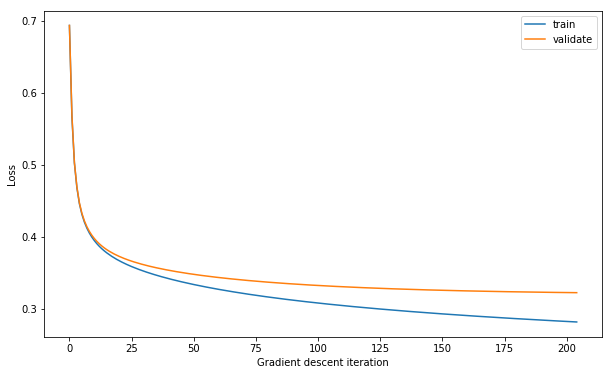

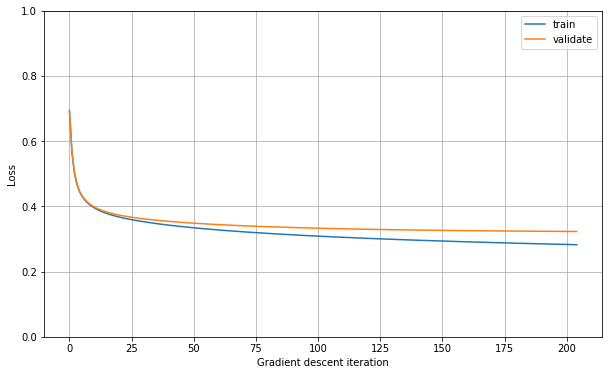

In [15]:
for i in range(2):
    plt.figure(figsize=(10, 6))
    plt.plot(range(iterations), losses_train, label='train')
    plt.plot(range(iterations), losses_valid, label='validate')
    plt.xlabel('Gradient descent iteration')
    plt.ylabel('Loss')
    if i == 1:
        plt.ylim(0, 1)
        plt.grid(True)
    plt.legend()
    plt.show()

In [16]:
print(u"Минимум ошибки для тестовой выборки наблюдается на {} итерации.".format(np.argmin(losses_valid)))

Минимум ошибки для тестовой выборки наблюдается на 204 итерации.


Можно сделать вывод, что ошибка (среднее значение функции потерь) на обучающей выборке постоянно падала почти с каждым шагом градиентного метода. Для тестовой выборки функция ошибки вначале также падала, но после приблизительно 4000 итерации стала возрастать, то есть начало наблюдаться переобучение.

# Реализуйте выбор шага градиентного спуска методом Армихо. Ускорило ли использование метода Армихо с начальными параметрами
$$ s=100, \beta=\alpha=0.5,$$
где $s$ - начальный шаг, $\beta$ - коэффициент уменьшения шага, $\alpha$ - коэффициент в неравенстве.
# достижение минимума на обучающей выборке по сравнению с фиксированным шагом 100? А на валидационной?

In [17]:
# Функция выбора шага градиентного спуска методом Армихо
def armijo (W, b, x, y, dW, db, alpha=0.5, beta=0.5, s=100):
    # Считаем функцию потерь в данной точке
    loss_current = loss(y, softmax(W, b, x))
    # Считаем скалярное произведение направления (антиградиента) и градиента функции
    scalar_product = - ((dW ** 2).sum() + (db ** 2).sum())
    # Считаем вектор-предсказание для следующих W и b
    pred_next = softmax(W - s * dW, b - s * db, x)
    # И функцию потерь для следующих W и b
    loss_next = loss(y, pred_next)
    while loss_next - loss_current > alpha * s * scalar_product:
        s *= beta
        pred_next = softmax(W - s * dW, b - s * db, x)
        loss_next = loss(y, pred_next)
    return s

In [18]:
def gradient_descent_method_armijo(x_train, y_train, x_test, y_test, iterations, alpha=0.5, beta=0.5, s=0.1):
    # Определяем размерность параметров. Сколько их всего?
    m = y_train[0].shape[0]
    n = x_train[0].shape[0]
    W = np.zeros((m, n))
    b = np.zeros(m)
    
    # Будем записывать среднее значение потери на каждом шаге спуска
    losses_train=[]
    losses_valid=[]
    
    # Сам градиентный спуск
    for i in tqdm.tqdm(range(iterations)):
        p_train = softmax(W, b, x_train)
        p_test = softmax(W, b, x_test)
        losses_train.append(loss(y_train, p_train))
        losses_valid.append(loss(y_test, p_test))
        dW, db = gradients(p_train, x_train, y_train)
        step = armijo (W, b, x_train, y_train, dW, db, alpha, beta, s)
        W -= step * dW
        b -= step * db
    return (W, b, losses_train, losses_valid)

In [19]:
# iterations = 500
# W1, b1, losses_train1, losses_valid1 = gradient_descent_method_armijo(x_train, y_train, x_test, y_test, iterations)
# W2, b2, losses_train2, losses_valid2 = gradient_descent_method_const(x_train, y_train, x_test, y_test, 100, iterations)

In [20]:
# for i in range(2):
#     plt.figure(figsize=(10, 6))
#     plt.plot(range(iterations), losses_train1, label='train (armijo)')
#     plt.plot(range(iterations), losses_valid1, label='validate (armijo)')
# #     plt.plot(range(iterations), losses_train2, label='train (constant step)')
# #     plt.plot(range(iterations), losses_valid2, label='validate (constant step)')
#     plt.xlabel('Gradient descent iteration')
#     plt.ylabel('Loss')
#     if i != 0:
#         plt.grid(True)
#     if i == 1:
#         plt.ylim(0, 1)
#     plt.legend()
#     plt.show()

In [21]:
# print(u"Минимум ошибки для тестовой выборки при использовании правила Армихо наблюдается "
#       "на {} итерации.".format(np.argmin(losses_valid1)))
# # print(u"Минимум ошибки для тестовой выборки при использовании постоянного шага наблюдается "
# #       "на {} итерации.".format(np.argmin(losses_valid2)))

Как мы можем видеть из второго графика, использование выбора шага по правилу Армихо замедлило достижения минимума на обучающей выборке по сравнению с фиксированным шагом 100. На валидационной выборке (см. третий график) метод градиентного спуска с выбором шага по правилу Армихо очень быстро достиг своего минимума (на 160 итерации) по сравнению с постоянным шагом, который не достиг своего минимума за 5000 итераций.

# Какую долю картинок из валидационной выборки удается предсказать правильно? Приведите примеры из валидационной выборки, где модель ошибается и где работает правильно

Для данной части будем использовать модель, обученную в самом начале (5000 итераций метода градиентного спуска с постоянным шагом 1).

In [22]:
def classify_sample(W, b, x, y):
    pred = softmax(W, b, x)
    correct = []
    wrong = []
    for i in range(pred.shape[0]):
        if y[i][np.argmax(pred[i])] == 1:
            correct.append((x[i], y[i], pred[i]))
        else:
            wrong.append((x[i], y[i], pred[i]))
    return (correct, wrong)

In [23]:
correct, wrong = classify_sample(W, b, x_test, y_test)

In [24]:
print(u"Доля валидационной выборки, предсказанная правильно, равна", len(correct) / (len(correct) + len(wrong)))

Доля валидационной выборки, предсказанная правильно, равна 0.871434839842036


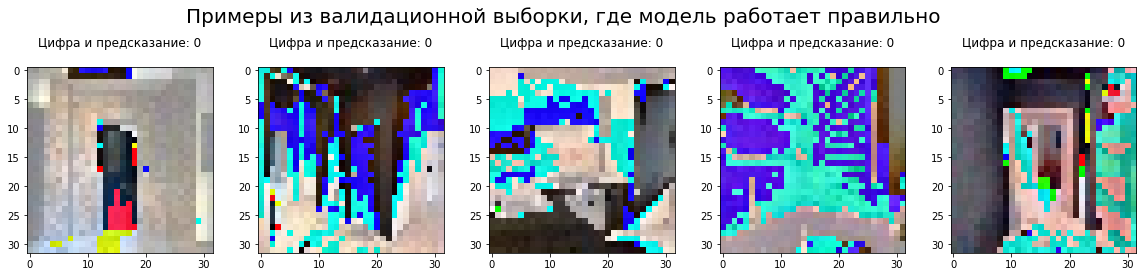

In [25]:
fig = plt.figure(figsize=(20, 4))
plt.suptitle(u"Примеры из валидационной выборки, где модель работает правильно", fontsize=20)
fig.subplots_adjust(top=0.77)
for index, (x, y, pred) in enumerate(correct[0:5]):
    ax = fig.add_subplot(1, 5, index + 1)
    ax.imshow(np.reshape(x, (32, 32, 3)), cmap=plt.cm.gray)
    ax.set_title(u"Цифра и предсказание: {}\n".format(np.argmax(pred)), fontsize=12)

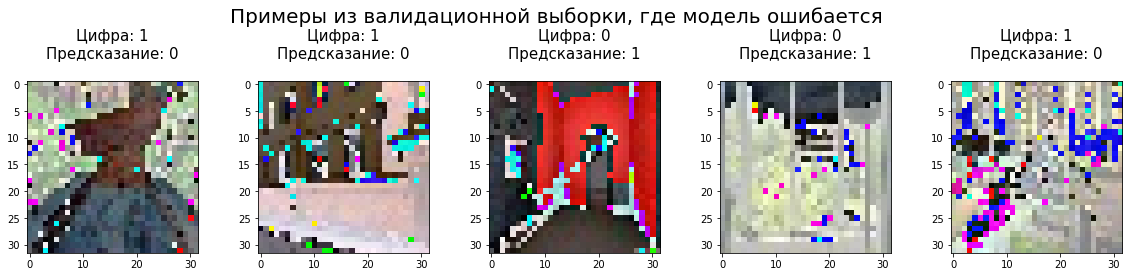

In [26]:
fig = plt.figure(figsize=(20, 4))
plt.suptitle(u"Примеры из валидационной выборки, где модель ошибается", fontsize=20)
fig.subplots_adjust(top=0.72)
for index, (x, y, pred) in enumerate(wrong[0:5]):
    ax = fig.add_subplot(1, 5, index+1)
    ax.imshow(np.reshape(x, (32, 32, 3)), cmap=plt.cm.gray)
    ax.set_title(u"Цифра: {}\nПредсказание: {}\n".format(np.argmax(y), np.argmax(pred)), fontsize=15)

In [27]:
pics_valid = []
answers_valid = []
max_number = 2959
pathname = './test'

for i in range(max_number + 1):
    filename = "img_" + str(i) + ".jpg"
    pics_valid.append(sp.misc.imread(os.path.join(pathname, filename)).flatten())

pics_valid = np.array(pics_valid)
pics_valid = (pics_valid - 127.5) / 255

/home/user/study/OptimizationMethods/lin_prog/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [28]:
pred = softmax(W, b, pics_valid)
for i in range(pred.shape[0]):
    answers_valid.append(np.argmax(pred[i]))

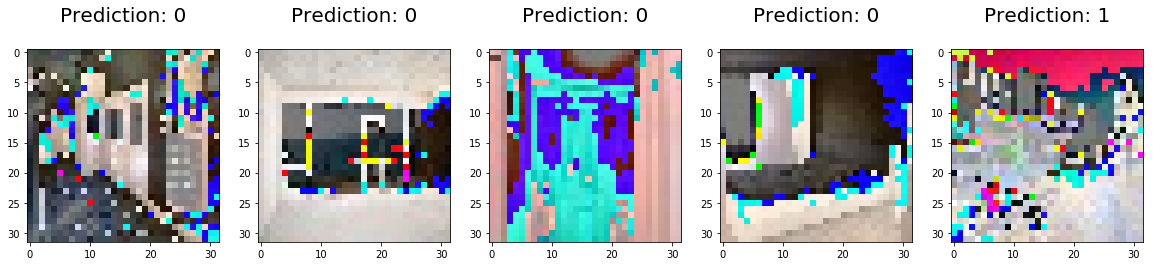

In [29]:
plt.figure(figsize=(20, 4))

for index, (image, label) in enumerate(zip(pics_valid[0:5], answers_valid[0:5])):
    plt.subplot(1, 5, index+1)
    plt.imshow(np.reshape(image, (32, 32, 3)), cmap=plt.cm.gray)
    plt.title('Prediction: %i\n' % label, fontsize = 20)

In [31]:
with open('result.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerow(["id"] + ["res"])
    for i in range(max_number + 1):
        writer.writerow([i] + [1 - answers_valid[i]])